### Neural Network (Feedforward Multi-Layer Perceptron)

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
print("Import successful")

Import successful


In [4]:
## Helper Functions
def drop_na(merged_df):
    merged_df = merged_df.dropna()
    merged_df.reset_index(drop=True, inplace=True)
    return merged_df

def apply_lag_features(merged_df):
    # add previous one-day values
    merged_df["prev1_open"] = merged_df["Open"].shift(1)
    merged_df["prev1_close"] = merged_df["Close"].shift(1)

    # add previous two-day values
    merged_df["prev2_open"] = merged_df["Open"].shift(2)
    merged_df["prev2_close"] = merged_df["Close"].shift(2)

    # previous 1 day sentiment
    merged_df["prev1_sentiment_compound"] = merged_df["sentiment_compound"].shift(1)

    # previous 2 day sentiment
    merged_df["prev2_sentiment_compound"] = merged_df["sentiment_compound"].shift(2)

    # previous 1 day volume
    merged_df["prev1_volume"] = merged_df["Volume"].shift(1)

    # previous 2 day volume
    merged_df["prev2_volume"] = merged_df["Volume"].shift(2)

    
    return merged_df

In [5]:
## Run Neural Network Model
def nn_model(df):
    features = [
        'Open', 'Close', 'Volume', 'sentiment_compound', 'prev1_open', 'prev1_close','prev1_volume',
        'prev2_volume', 'prev2_open', 'prev2_close', 'prev1_sentiment_compound',
        'prev2_sentiment_compound'
    ]

    X = df[features]
    y = df['target'].astype(float)  # goal is to predict the next day's closing price (classification)

    valid_idx = np.isin(y, [-1, 1]) # removing any row that does not have -1 or 1 as target
    X = X[valid_idx]
    y = y[valid_idx]

    # scale features in order to avoid certain features from dominating others
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )

    # Create neural network with 3 hidden layers
    nn = MLPClassifier(
        hidden_layer_sizes=(64, 32, 16),
        activation='relu',
        solver='adam',
        learning_rate_init=0.001,
        max_iter=500,
        random_state=42
    )

    # train on the scaled training data
    nn.fit(X_train, y_train)

    y_pred = nn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("Test set accuracy:", acc)

    # # confusion matrix
    # cm = confusion_matrix(y_test, y_pred)
    # print("Confusion Matrix:\n", cm)

    # # classification report
    # report = classification_report(y_test, y_pred)
    # print(report)

In [8]:
# Getting all stocks
stocks = ['AAPL', 'GOOG', 'INTC', 'META', 'MSFT']

for stock in stocks:
    print(stock)
    stock_finance_df = pd.read_csv(f'../{stock} Data/{stock}_finance_data.csv')
    stock_sentiment_df = pd.read_csv(f'../{stock} Data/{stock}_avg_sentiment_data.csv')
    merged_stock_df = pd.merge(stock_finance_df, stock_sentiment_df, on='Date', how='inner')
    merged_stock_df = apply_lag_features(merged_stock_df)
    merged_stock_df = drop_na(merged_stock_df)
    print(f"Num of rows, ", len(merged_stock_df))
    nn_model(merged_stock_df)
    print("\n")

AAPL
Num of rows,  250
Test set accuracy: 0.84


GOOG
Num of rows,  236
Test set accuracy: 0.8125


INTC
Num of rows,  131
Test set accuracy: 0.6538461538461539


META
Num of rows,  217
Test set accuracy: 0.6590909090909091


MSFT
Num of rows,  250
Test set accuracy: 0.86




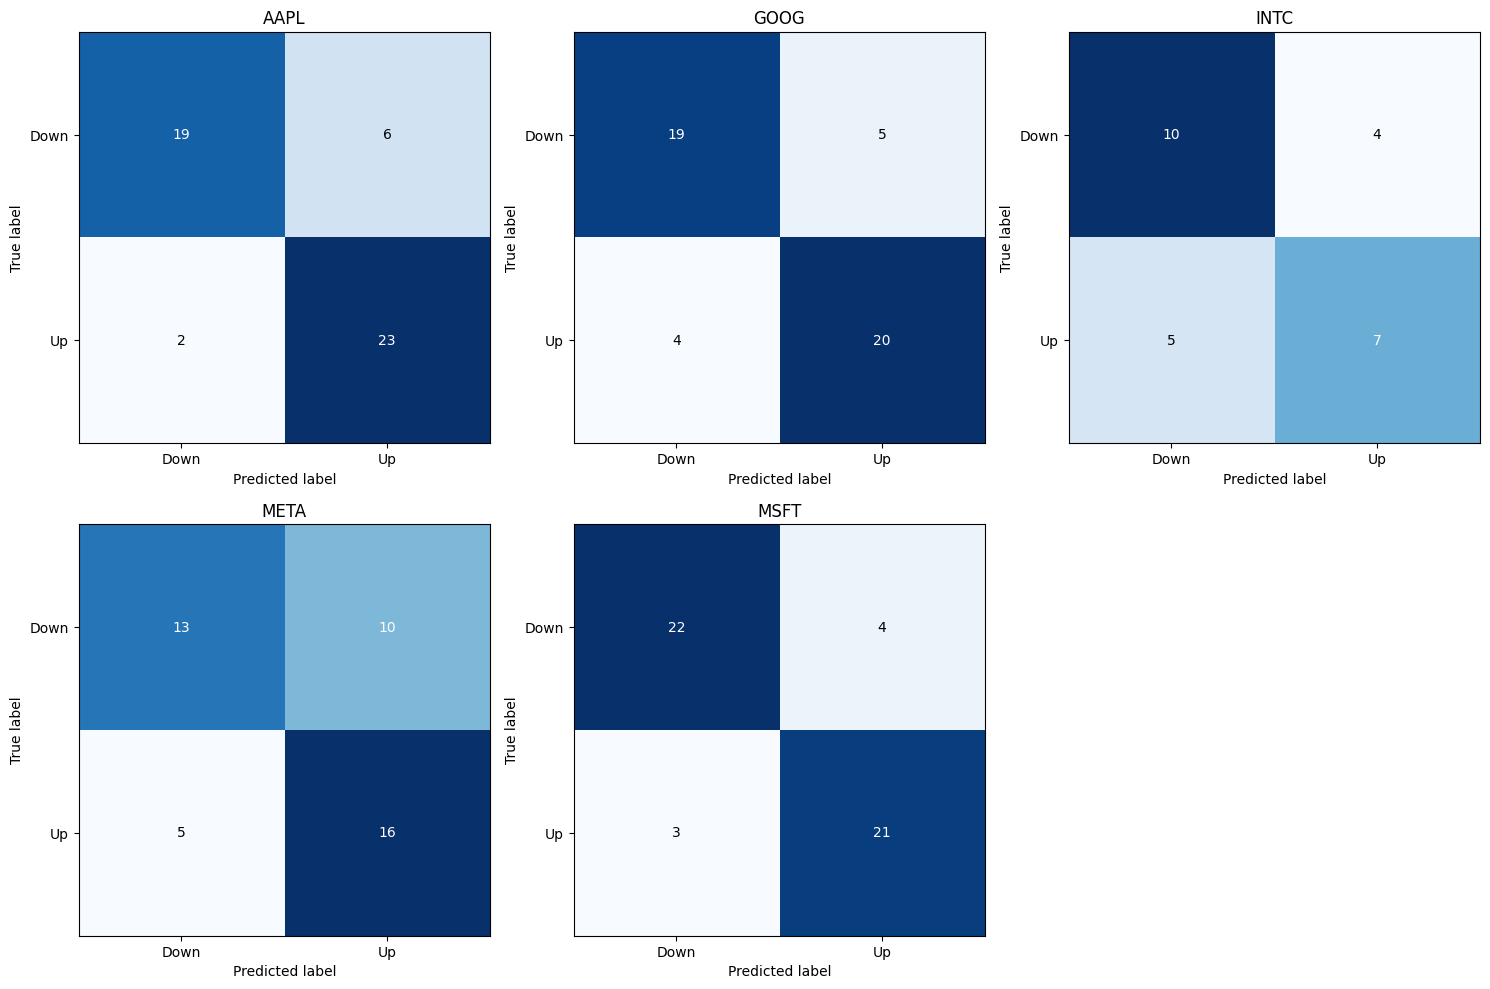

In [10]:
## Confusion Matrix for All Stocks

stocks = ['AAPL', 'GOOG', 'INTC', 'META', 'MSFT']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, stock in enumerate(stocks):
    stock_finance_df = pd.read_csv(f'../{stock} Data/{stock}_finance_data.csv')
    stock_sentiment_df = pd.read_csv(f'../{stock} Data/{stock}_avg_sentiment_data.csv')
    merged_stock_df = pd.merge(stock_finance_df, stock_sentiment_df, on='Date', how='inner')
    merged_stock_df = apply_lag_features(merged_stock_df)
    merged_stock_df = drop_na(merged_stock_df)
    
    features = [
        'Open', 'Close', 'Volume', 'sentiment_compound', 'prev1_open', 'prev1_close','prev1_volume',
        'prev2_volume', 'prev2_open', 'prev2_close', 'prev1_sentiment_compound',
        'prev2_sentiment_compound'
    ]

    X = merged_stock_df[features]
    y = merged_stock_df['target'].astype(float)
    valid_idx = np.isin(y, [-1, 1])
    X = X[valid_idx]
    y = y[valid_idx]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )

    nn = MLPClassifier(
        hidden_layer_sizes=(64, 32, 16),
        activation='relu',
        solver='adam',
        learning_rate_init=0.001,
        max_iter=500,
        random_state=42
    )
    nn.fit(X_train, y_train)
    y_pred = nn.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    im = axes[idx].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[idx].set_title(f'{stock}')
    tick_marks = np.arange(2)
    axes[idx].set_xticks(tick_marks)
    axes[idx].set_yticks(tick_marks)
    axes[idx].set_xticklabels(['Down', 'Up'])
    axes[idx].set_yticklabels(['Down', 'Up'])
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[idx].text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    axes[idx].set_ylabel('True label')
    axes[idx].set_xlabel('Predicted label')

# Hide the extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()